<a href="https://colab.research.google.com/github/wlau0721/Disaster-Tweets-RNN--CuB-DeepLearningWk4/blob/main/Disaster_Tweets_RNN_CuB_DeepLearningWk4v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brief description of the problem and data (5 pts)

This project focuses on analyzing Twitter messages. Twitter has become a crucial communication channel during emergencies. As a result, many agencies, such as disaster relief organizations and news agencies, are interested in programmatically monitoring Twitter.

The goal of this project is to develop a machine learning model that can distinguish between Tweets about real disasters and those that are not.



# Data Description

The entire dataset consists of just two files, containing approximately 10,000 tweets in total, with a combined size of 1.43 MB.

#### Files
- train.csv - the training set
- test.csv - the test set

Both the train and test files contain 5 columns.  

#### Columns
- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)



# Environment setup and parameter setting

In [ ]:
#python basics
from matplotlib import pyplot as plt
import math, os, re, time, random, string
import numpy as np, pandas as pd, seaborn as sns

#this is just cool
from tqdm import tqdm

#visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')   #for optimum aesthetics
import seaborn as sns

#natural language processing
from collections import defaultdict
import wordcloud

#ignore warnings because they are annoying
import warnings
warnings.filterwarnings('ignore')

#for neural nets
import tensorflow as tf

# Keras
from keras.preprocessing.sequence import pad_sequences
from keras import Input
from keras.preprocessing.text import Tokenizer

def seed_everything(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

seed_everything(42)  # my change

# Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

The dataset mainly has two csv files:
- train.csv - the training set
- test.csv - the test set

There are 5 columns across these two files:
- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)


## Loading data

In [ ]:
# mount colab notebook to Google drive folder
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

train = pd.read_csv('/content/drive/MyDrive/CuBoulder/DTSA5511DeepLearning/wk4/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/CuBoulder/DTSA5511DeepLearning/wk4/data/test.csv')

Mounted at /content/drive


### Explorating the two csv files

The train dataframe contains 7,613 rows and has a significant number of null values in the keyword and location columns, particularly in the location column.

The test dataframe contains 3,263 rows and also has null values in the keyword and location columns, similar to the train dataframe.


In [ ]:
print('There are', len(train), 'rows in the train set')
print('There are', len(test), 'rows in the test set')

print("Train.csv")
train.info()
train.describe()
print(train.head())

print("test.csv")
test.info()
test.describe()
print(test.head())

There are 7613 rows in the train set
There are 3263 rows in the test set
Train.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1     

### Checking label balance

The target column is relatively well-balanced, with 4,342 instances labeled as zero (not a disaster) and 3,271 instances labeled as one (disaster).

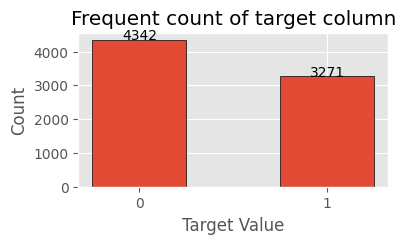

In [ ]:
value_counts = train['target'].value_counts()  #count target label

plt.figure(figsize=(4, 2))
plt.bar(value_counts.index, value_counts.values, width=0.5, edgecolor='black')
plt.title('Frequent count of target column')
plt.xticks([0, 1], ['0', '1'])
plt.xlabel('Target Value')
plt.ylabel('Count')

# Add total count for each value
for i, count in enumerate(value_counts.values):
    plt.text(i, count + 10, f"{int(count)}", ha='center')

plt.show()

### Analyzing the text in the text column

The following chart shows the distribution of tweet word counts, comparing tweets that mention disasters with those that do not. The word count distribution for disaster tweets is a bit taller with a smaller standard deviation compared to non-disaster tweets, although their means are similar, around 15 words per tweet.

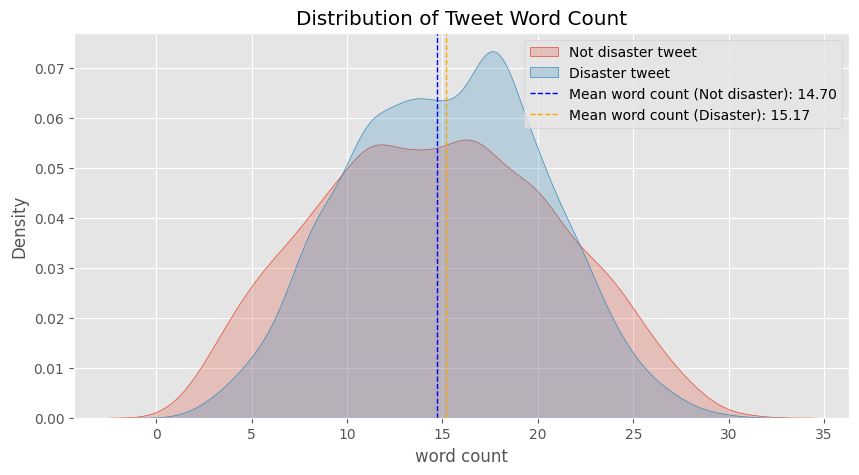

In [ ]:
#create column for the number of words in tweet
train['word count'] = train['text'].apply(lambda x: len(x.split()))

#split so we can use updated train set with new feature
#train = total[:len(train)]

# Calculate mean word count for disaster and non-disaster tweets
mean_word_count_disaster = train['word count'][train['target'] == 1].mean()
mean_word_count_non_disaster = train['word count'][train['target'] == 0].mean()

#define subplot to see graphs side by side
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
sns.kdeplot(train['word count'][train['target'] == 0], shade = True, label = 'Not disaster tweet')
sns.kdeplot(train['word count'][train['target'] == 1], shade = True, label = 'Disaster tweet')

# Add vertical lines for average word count
ax.axvline(mean_word_count_non_disaster, color='blue', linestyle='dashed', linewidth=1, label=f'Mean word count (Not disaster): {mean_word_count_non_disaster:.2f}')
ax.axvline(mean_word_count_disaster, color='orange', linestyle='dashed', linewidth=1, label=f'Mean word count (Disaster): {mean_word_count_disaster:.2f}')

#set title and plot
plt.title('Distribution of Tweet Word Count')
plt.legend()
plt.show()

### finding the most popular words from tweet text

The following output shows the high-frequency words among all the tweets, sorted in descending order. As expected, the highest frequency words include "the," "a," "to," "of," and "and." Removing these common words from the dataset may be beneficial, as they are unlikely to add tangible value to improving the machine learning model's performance.

In [ ]:
#Count the freqency of the words in all train['text'] column and show the word in the decending order of their count.
from collections import Counter
word_count = Counter()
for text in train['text']:
  for word in text.split():
    word_count[word] += 1
# Sort the word_count dictionary by count
sorted_word_count = sorted(word_count.items(), key=lambda x: x[1], reverse=True)
# Print the word frequency
for word, count in sorted_word_count[:25]:
  print(f"{word}: {count}")

the: 2575
a: 1845
to: 1805
in: 1757
of: 1722
and: 1302
I: 1197
for: 820
is: 814
on: 773
-: 763
you: 632
The: 552
my: 549
with: 508
that: 492
at: 485
by: 469
it: 433
from: 372
be: 371
was: 363
have: 353
are: 345
this: 335


### checking again what value of keyword and location at test df

In [ ]:
import pandas as pd

# Assuming 'test' DataFrame is already defined

# Count NaN values in 'keyword' column
keyword_nan_count = test['keyword'].isna().sum()

# Count NaN values in 'location' column
location_nan_count = test['location'].isna().sum()

print(f"Number of NaN values in 'keyword' column: {keyword_nan_count}")
print(f"Number of NaN values in 'location' column: {location_nan_count}")


Number of NaN values in 'keyword' column: 26
Number of NaN values in 'location' column: 1105


### Cleaning up data


The cleanup tasks for the train and test dataframes are as follows:
- Drop the 'id' column since it does not contribute to predicting whether the tweet is about a disaster.
- Fill missing values in the 'keyword' and 'location' columns with "unknown".
- Merge the tweet's keywords into the text columns and drop the 'keyword' column afterwards.

In [ ]:
#save ID
#test_id = test.index.values
test_id = test['id']

#drop from train and test
#columns = {'id', 'location'}  #my change
columns = {'id'}  #my change
train = train.drop(columns = columns)
test = test.drop(columns = columns)

#fill missing with unknown
train['keyword'] = train['keyword'].fillna('unknown')
test['keyword'] = test['keyword'].fillna('unknown')
train['location'] = train['location'].fillna('unknown')  # my change added
test['location'] = test['location'].fillna('unknown') # my change added

#add keyword to tweets
train['text'] = train['text'] + ' ' + train['keyword']
test['text'] = test['text'] + ' ' + test['keyword']

#drop keyword from train and test
columns = {'keyword'}
train = train.drop(columns = columns)
test = test.drop(columns = columns)

#combine so we work smarter, not harder
#total = train.append(test)  #deprecated
total = pd.concat([train, test], ignore_index=False)   # my change

### generating meta data columns from tweet text

Metadata in addition to the tweet text could potentially enhance the model's performance. New derived data from the text column could include metrics such as unique word count, stopword count, stopword ratio, and punctuation count.

In [ ]:
#add unique word count
total['unique word count'] = total['text'].apply(lambda x: len(set(x.split())))

#add stopword count
total['stopword count'] = total['text'].apply(lambda x: len([i for i in x.lower().split() if i in wordcloud.STOPWORDS]))

#add stopword ratio
total['stopword ratio'] = total['stopword count'] / total['word count']

#add punctuation count
total['punctuation count'] = total['text'].apply(lambda x: len([i for i in str(x) if i in string.punctuation]))

#split so we can use updated train set
train = total[:len(train)]

disaster = train['target'] == 1

# cleaning tweet text

Basic cleanup processes are applied to the tweet text, which involve removing punctuation, mentions, URLs, and non-alphanumeric characters. This leaves only the remaining words separated by spaces.


In [ ]:
def remove_punctuation(x):
    return x.translate(str.maketrans('', '', string.punctuation))

def strip_all_entities(x):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())

total['text'] = total['text'].apply(remove_punctuation).apply(strip_all_entities)

### tokenizing text

In [ ]:
tweets = [tweet for tweet in total['text']]

#split data to update changes
train = total[:len(train)]
test = total[len(train):]

#define tokenizer options
to_exclude = '*+-/()%\n[\\]{|}^_`~\t'
tokenizer = Tokenizer()
tokenizer = Tokenizer(oov_token='<OOV>', filters=to_exclude)
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)

word_index = tokenizer.word_index

data = pad_sequences(sequences)
labels = train['target']

# prepare input data and label
nlp_train = data[:len(train)]
labels = labels
nlp_test = data[len(train):]

MAX_SEQUENCE_LENGTH = data.shape[1]

###########################
# creating GloVe vector embeddings
embeddings_index = {}
with open('/content/drive/MyDrive/CuBoulder/DTSA5511DeepLearning/wk4/data/glove.6B.200d.txt','r') as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()
###########################
# set the size of vector dimensions
EMBEDDING_DIM = 200
###########################
#initialize embedding matrix with zeros
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        #words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print("The dimension of the embedded matrix is: ", embedding_matrix.shape)
###########################
#import neural network basic
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout, Concatenate, LeakyReLU, GRU, ReLU  #my change to add ReLU
from keras import Input, Model, regularizers
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping

embedding = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [embedding_matrix],
                     input_length = MAX_SEQUENCE_LENGTH, trainable = False)  # trainable = False for pretrained data
###########################

400001it [00:33, 11922.39it/s]
100%|██████████| 28901/28901 [00:00<00:00, 307221.01it/s]

The dimension of the embedded matrix is:  (28902, 200)


### rescaling the meta columns

The metadata columns are scaled using the StandardScaler library.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
def scale(df, scaler):
    return scaler.fit_transform(df.iloc[:, 2:])
meta_train = scale(train, StandardScaler())
meta_test = scale(test, StandardScaler())

# Model Architecture (25 pts)

Due to the sequential nature of tweet text, an RNN like LSTM would be a suitable choice for applying machine learning techniques. Initially, we will start with a simple network to establish the ML workflow. Version 1 of the model will use basic ReLU activation, a non-bidirectional LSTM layer, and a Dense sigmoid output layer.

Depending on the modeling outcomes, additional advanced features may be incorporated into the model. Examples include:
- Adding dropout layers such as SpatialDropout.
- Incorporating tweet metadata into the input.
- Introducing bidirectional LSTM layers.
- Including multiple additional dropout and LSTM layers.

## Building version 1 of the LSTM

The first version of this model is relatively simple, featuring ReLU activation, a single layer of non-bidirectional LSTM, and a sigmoid output layer.

In [ ]:
# first version

def create_lstm(spatial_dropout, dropout, recurrent_dropout, learning_rate, bidirectional = False):
    # define activation
    activation = ReLU()
    # define input
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    emb = embedding(nlp_input)
    # add LSTM layer
    if bidirectional:
        nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal')))(emb)
    else:
        nlp_out = (LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal'))(emb)
    # add output layer
    x = nlp_out
    preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)
    # compile model
    model = Model(inputs=nlp_input, outputs = preds)
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

    return model

In [ ]:
#create first model
lstm = create_lstm(spatial_dropout = .2, dropout = .2, recurrent_dropout = .2,
                     learning_rate = 3e-4, bidirectional = False)  # my change to False
lstm.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 nlp_input (InputLayer)      [(None, 32)]              0         
                                                                 
 embedding (Embedding)       (None, 32, 200)           5780400   
                                                                 
 lstm (LSTM)                 (None, 100)               120400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 5900901 (22.51 MB)
Trainable params: 120501 (470.71 KB)
Non-trainable params: 5780400 (22.05 MB)
_________________________________________________________________


In [ ]:
#fit model
history1 = lstm.fit(nlp_train, labels, validation_split=0.2, epochs=5, batch_size=21, verbose=1)  # my change

Epoch 1/5
290/290 [==============================] - 27s 78ms/step - loss: 0.5056 - accuracy: 0.7631 - val_loss: 0.4385 - val_accuracy: 0.8089
Epoch 2/5
290/290 [==============================] - 31s 109ms/step - loss: 0.4346 - accuracy: 0.8122 - val_loss: 0.4119 - val_accuracy: 0.8207
Epoch 3/5
290/290 [==============================] - 22s 76ms/step - loss: 0.4184 - accuracy: 0.8192 - val_loss: 0.4132 - val_accuracy: 0.8175
Epoch 4/5
290/290 [==============================] - 27s 93ms/step - loss: 0.4063 - accuracy: 0.8278 - val_loss: 0.4091 - val_accuracy: 0.8089
Epoch 5/5
290/290 [==============================] - 26s 88ms/step - loss: 0.3970 - accuracy: 0.8312 - val_loss: 0.4064 - val_accuracy: 0.8201


In [ ]:
#plot accrucy and loss over epochs to visualize performance
def plot_learning_curves(history,title):
    fig, ax = plt.subplots(1, 2, figsize = (20, 5))

    epochs = range(1, len(history.history['accuracy']) + 1)

    ax[0].plot(epochs, history.history['accuracy'])
    ax[0].plot(epochs, history.history['val_accuracy'])
    ax[0].set_title('Accuracy')

    # Add text annotations for accuracy values
    for i, (train_acc, val_acc) in enumerate(zip(history.history['accuracy'], history.history['val_accuracy'])):
        ax[0].text(i+1, train_acc, f"{train_acc:.2f}", ha='center', va='bottom')
        ax[0].text(i+1, val_acc, f"{val_acc:.2f}", ha='center', va='top')

    ax[1].plot(epochs, history.history['loss'])
    ax[1].plot(epochs, history.history['val_loss'])
    ax[1].set_title('Loss')

    # Add text annotations for loss values
    for i, (train_loss, val_loss) in enumerate(zip(history.history['loss'], history.history['val_loss'])):
        ax[1].text(i+1, train_loss, f"{train_loss:.2f}", ha='center', va='top')
        ax[1].text(i+1, val_loss, f"{val_loss:.2f}", ha='center', va='bottom')

    ax[0].legend(['train', 'validation'], loc = 'upper left')
    ax[1].legend(['train', 'validation'], loc = 'upper right')

    fig.suptitle(title)

    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')

    return plt.show()

## Version 1 model result

The results of the first minimal version of the model are actually quite promising. It achieves a training accuracy of 0.83 after just 5 epochs, with relatively quick training time.

For the next version, I plan to enhance the model by using Leaky ReLU activation and adding dropout layers to mitigate overfitting. As the model performance shows potential for improvement, I will also increase the number of epochs to achieve a better model outcome.

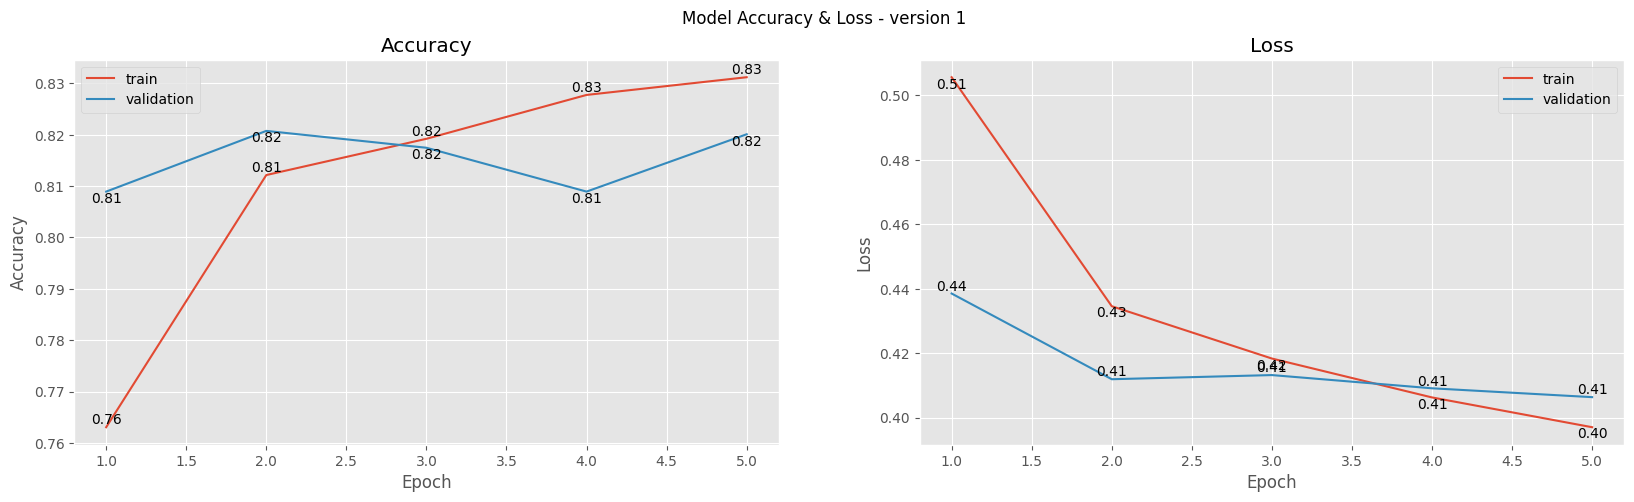

In [ ]:
#view model 0 learning curves - no meta_train layer
title = "Model Accuracy & Loss - version 1"
plot_learning_curves(history1, title)

# Results and Analysis (35 pts)

The train and validation accuracy are stable around 80%, with no obvious issues in accuracy and loss.

Next, I will increase the number of epochs, explore different architectures, and conduct hyperparameter tuning to enhance the model's performance.

## Building version 2 of the LSTM

In the second version of this model, LeakyReLU will be used as the activation function. Additionally, SpatialDropout1D will be applied to the input layer, while additional dropout will be added to the output layer. The model will be trained for 20 epochs to explore potential improvements in performance.

In [ ]:
# second version
from keras.layers import ReLU  # my change added this import but could be removed later.

def create_lstm(spatial_dropout, dropout, recurrent_dropout, learning_rate, bidirectional = False):
    # define activation
    activation = LeakyReLU(alpha = 0.01)
    # define input
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(dropout)(emb)
    # add LSTM layer
    if bidirectional:
        nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal')))(emb)
    else:
        nlp_out = (LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal'))(emb)

    # add output layer
    x = Dropout(dropout)(nlp_out)
    preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)
    # compile model
    model = Model(inputs=nlp_input, outputs = preds)
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

    return model

In [ ]:
#create second model
lstm = create_lstm(spatial_dropout = .2, dropout = .2, recurrent_dropout = .2,
                     learning_rate = 3e-4, bidirectional = False)  # my change to False
lstm.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 nlp_input (InputLayer)      [(None, 32)]              0         
                                                                 
 embedding (Embedding)       (None, 32, 200)           5780400   
                                                                 
 spatial_dropout1d (Spatial  (None, 32, 200)           0         
 Dropout1D)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 100)               120400    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                           

In [ ]:
#fit model
history2 = lstm.fit(nlp_train, labels, validation_split=0.2, epochs=20, batch_size=21, verbose=1)  # my change

Epoch 1/20
290/290 [==============================] - 23s 71ms/step - loss: 0.5242 - accuracy: 0.7452 - val_loss: 0.4367 - val_accuracy: 0.8004
Epoch 2/20
290/290 [==============================] - 25s 87ms/step - loss: 0.4612 - accuracy: 0.7905 - val_loss: 0.4143 - val_accuracy: 0.8194
Epoch 3/20
290/290 [==============================] - 30s 102ms/step - loss: 0.4457 - accuracy: 0.8028 - val_loss: 0.4090 - val_accuracy: 0.8122
Epoch 4/20
290/290 [==============================] - 24s 83ms/step - loss: 0.4321 - accuracy: 0.8094 - val_loss: 0.4103 - val_accuracy: 0.8148
Epoch 5/20
290/290 [==============================] - 32s 112ms/step - loss: 0.4304 - accuracy: 0.8110 - val_loss: 0.4078 - val_accuracy: 0.8162
Epoch 6/20
290/290 [==============================] - 28s 96ms/step - loss: 0.4206 - accuracy: 0.8172 - val_loss: 0.4096 - val_accuracy: 0.8155
Epoch 7/20
290/290 [==============================] - 25s 85ms/step - loss: 0.4135 - accuracy: 0.8210 - val_loss: 0.4035 - val_accurac

### Model 2 result:

In the second version, the training accuracy continues to improve, reaching 0.86 by epoch 20. However, the validation accuracy remains around 0.80. There appears to be slight overfitting, as the validation accuracy trends downward slightly after about 15 epochs, accompanied by an increase in loss.

For the next version, I plan to incorporate the metadata columns into the model training to assess any potential impact. Additionally, I will reduce the number of epochs to 15, as it seems that training beyond this point may not yield significant improvements in validation accuracy.

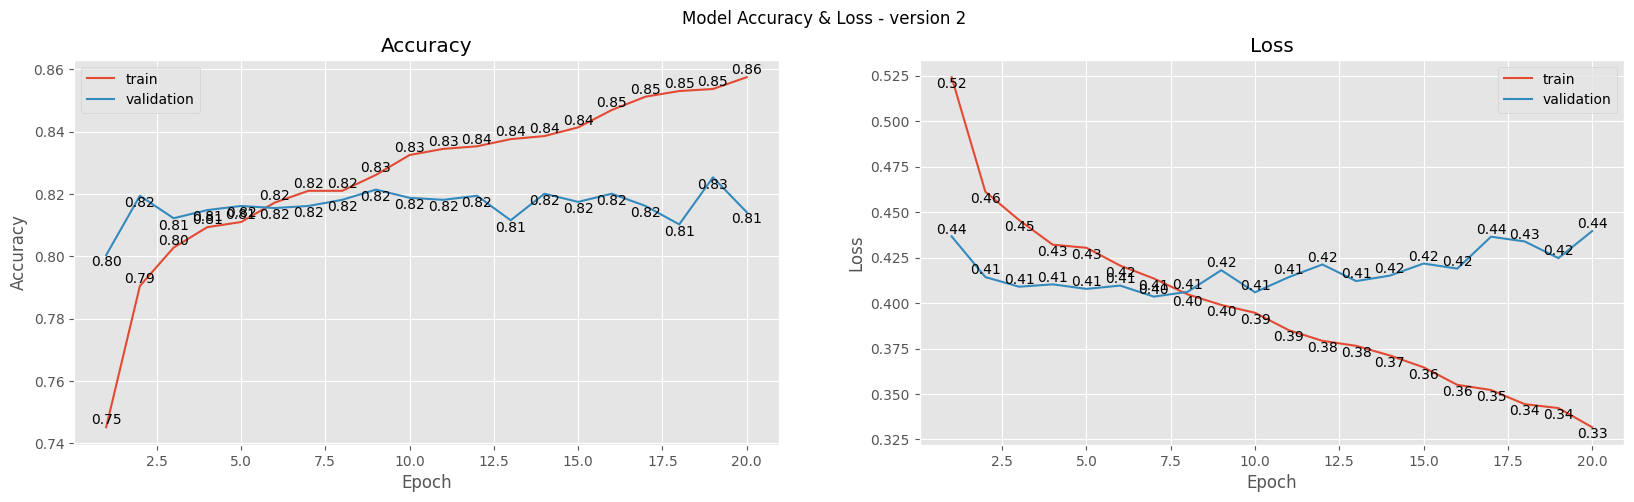

In [ ]:
#view model 2 learning curves - no meta_train layer
title = "Model Accuracy & Loss - version 2"
plot_learning_curves(history2, title)

### Third version of the model

The validation accuracy and loss appear to be stabilizing or slightly decreasing. In the next version of the model, I will include the metadata columns in the input layer and incorporate bidirectional LSTM layers. Bidirectional LSTM layers enable the model to utilize information from both past and future contexts, potentially enhancing prediction capabilities.

In [ ]:
# third version for  lstm model
def create_lstm(spatial_dropout, dropout, recurrent_dropout, learning_rate, bidirectional = False):
    #define activation
    activation = LeakyReLU(alpha = 0.01)

    #define inputs
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    meta_input_train = Input(shape = (6, ), name = 'meta_train')  # my change
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(dropout)(emb)
    #add LSTM layer
    if bidirectional:
        nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal')))(emb)
    else:
        nlp_out = (LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal'))(emb)

    #add meta data
    x = Concatenate()([nlp_out, meta_input_train])   # combining with meta data columns
    #add output layer
    x = Dropout(dropout)(x)
    preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)
    #compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

    return model

In [ ]:
#create third model
lstm = create_lstm(spatial_dropout = .2, dropout = .2, recurrent_dropout = .2,
                     learning_rate = 3e-4, bidirectional = True)  # my change to False
lstm.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 nlp_input (InputLayer)      [(None, 32)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 32, 200)              5780400   ['nlp_input[0][0]']           
                                                                                                  
 spatial_dropout1d_1 (Spati  (None, 32, 200)              0         ['embedding[2][0]']           
 alDropout1D)                                                                                     
                                                                                                  
 bidirectional (Bidirection  (None, 200)                  240800    ['spatial_dropout1d_1[0]

In [ ]:
#fit model

history3 = lstm.fit([nlp_train, meta_train], labels, validation_split = .2,
                       epochs = 15, batch_size = 21, verbose = 1)

Epoch 1/15
290/290 [==============================] - 49s 148ms/step - loss: 0.5628 - accuracy: 0.6990 - val_loss: 0.4591 - val_accuracy: 0.7899
Epoch 2/15
290/290 [==============================] - 38s 131ms/step - loss: 0.4698 - accuracy: 0.7867 - val_loss: 0.4217 - val_accuracy: 0.8096
Epoch 3/15
290/290 [==============================] - 45s 154ms/step - loss: 0.4330 - accuracy: 0.8079 - val_loss: 0.4036 - val_accuracy: 0.8122
Epoch 4/15
290/290 [==============================] - 49s 171ms/step - loss: 0.4057 - accuracy: 0.8220 - val_loss: 0.3812 - val_accuracy: 0.8319
Epoch 5/15
290/290 [==============================] - 40s 137ms/step - loss: 0.3777 - accuracy: 0.8360 - val_loss: 0.3611 - val_accuracy: 0.8313
Epoch 6/15
290/290 [==============================] - 37s 129ms/step - loss: 0.3546 - accuracy: 0.8491 - val_loss: 0.3444 - val_accuracy: 0.8503
Epoch 7/15
290/290 [==============================] - 50s 173ms/step - loss: 0.3307 - accuracy: 0.8621 - val_loss: 0.3206 - val_ac

### model version 3 results:

Version 3 shows promising performance with validation accuracy improving to 0.9 by epoch 15, indicating that the overfitting issue has been mitigated. Given the continued upward trend in performance, I will further enhance the model by adding multiple dropout layers and LSTM layers. Additionally, I will extend the training duration to 25 epochs to explore potential improvements in model accuracy and robustness.

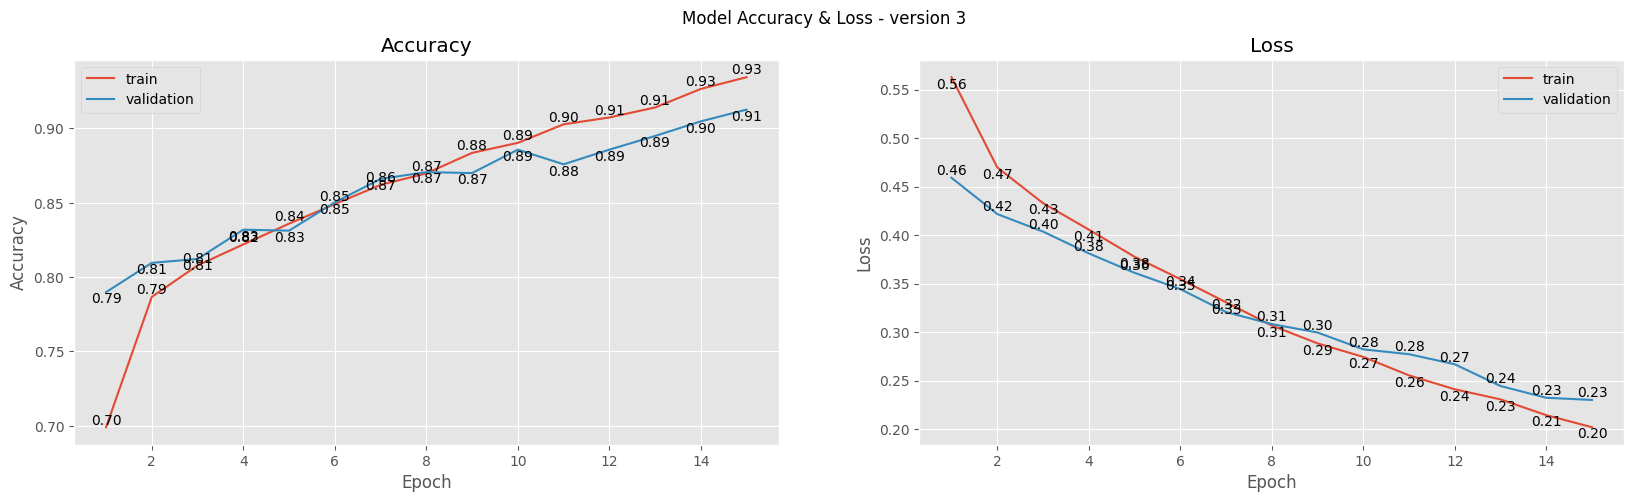

In [ ]:
#view model 3 learning curves
title = "Model Accuracy & Loss - version 3"
plot_learning_curves(history3, title)

# Version 4 model

In this version, I will incorporate multiple layers of LSTM and dense hidden layers into the model architecture.  

In [ ]:
def create_dual_lstm(spatial_dropout, dropout, recurrent_dropout, learning_rate, bidirectional = False):
    #define activation
    activation = LeakyReLU(alpha = 0.01)
    #define inputs
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    meta_input_train = Input(shape = (6, ), name = 'meta_train')
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(dropout)(emb)
    #add dual LSTM layers
    if bidirectional:
        nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal', return_sequences = True)))(emb)
        nlp_out = SpatialDropout1D(dropout)(nlp_out)
        nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal')))(emb)
    else:
        nlp_out = (LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal', return_sequences = True))(emb)
        nlp_out = SpatialDropout1D(dropout)(nlp_out)
        nlp_out = (LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal'))(emb)
    #add meta data
    x = Concatenate()([nlp_out, meta_input_train])
    #add second hidden layer
    x = Dropout(dropout)(x)
    x = (Dense(100, activation = activation, kernel_regularizer = regularizers.l2(1e-4),
              kernel_initializer = 'he_normal'))(x)
    #add output layer
    x = Dropout(dropout)(x)
    preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)
    #compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

    return model

In [ ]:
#create fourth model
lstm = create_lstm(spatial_dropout = .2, dropout = .2, recurrent_dropout = .2,
                     learning_rate = 3e-4, bidirectional = True)  # my change to False
lstm.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 nlp_input (InputLayer)      [(None, 32)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 32, 200)              5780400   ['nlp_input[0][0]']           
                                                                                                  
 spatial_dropout1d_2 (Spati  (None, 32, 200)              0         ['embedding[3][0]']           
 alDropout1D)                                                                                     
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 200)                  240800    ['spatial_dropout1d_2[0]

In [ ]:
history4 = lstm.fit([nlp_train, meta_train], labels, validation_split = .2,
                       epochs = 25, batch_size = 21, verbose = 1)

Epoch 1/25
290/290 [==============================] - 46s 138ms/step - loss: 0.5144 - accuracy: 0.7437 - val_loss: 0.4286 - val_accuracy: 0.8076
Epoch 2/25
290/290 [==============================] - 41s 141ms/step - loss: 0.4294 - accuracy: 0.8094 - val_loss: 0.3890 - val_accuracy: 0.8299
Epoch 3/25
290/290 [==============================] - 38s 130ms/step - loss: 0.3936 - accuracy: 0.8299 - val_loss: 0.3651 - val_accuracy: 0.8313
Epoch 4/25
290/290 [==============================] - 39s 134ms/step - loss: 0.3678 - accuracy: 0.8396 - val_loss: 0.3483 - val_accuracy: 0.8595
Epoch 5/25
290/290 [==============================] - 39s 133ms/step - loss: 0.3398 - accuracy: 0.8557 - val_loss: 0.3247 - val_accuracy: 0.8693
Epoch 6/25
290/290 [==============================] - 40s 137ms/step - loss: 0.3212 - accuracy: 0.8658 - val_loss: 0.3112 - val_accuracy: 0.8733
Epoch 7/25
290/290 [==============================] - 40s 137ms/step - loss: 0.2985 - accuracy: 0.8790 - val_loss: 0.2940 - val_ac

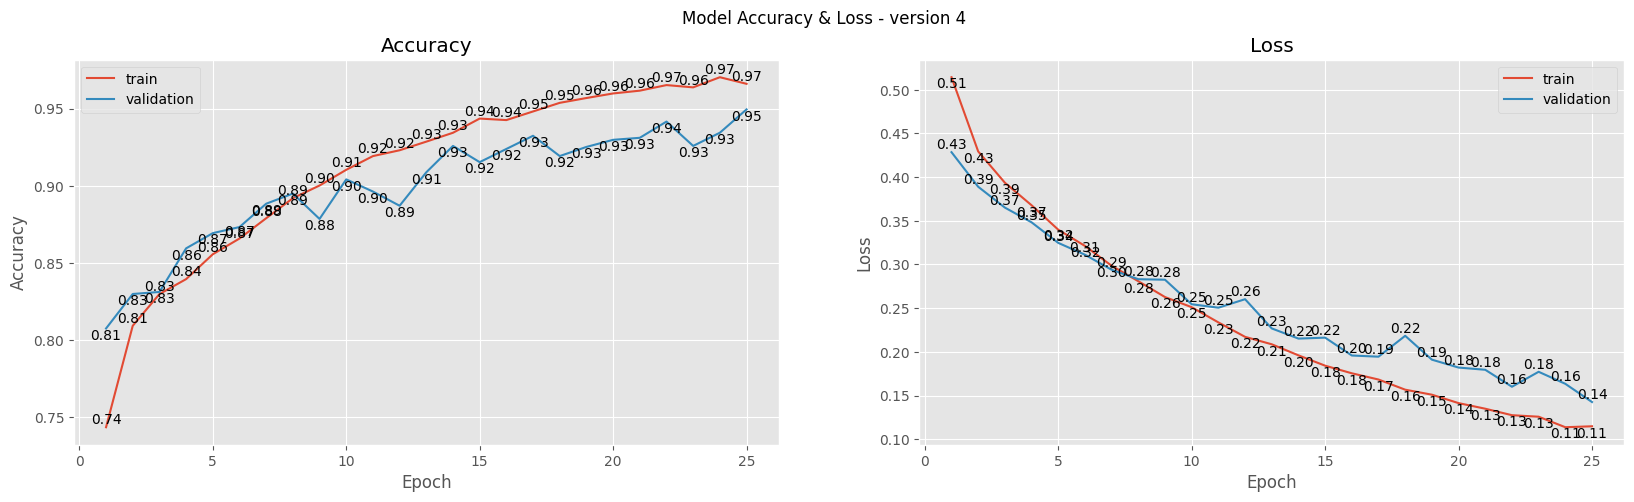

In [ ]:
#view model 4 learning curves
title = "Model Accuracy & Loss - version 4"
plot_learning_curves(history4, title)

# Conclusion (15 pts)

The final version of the model achieves a validation accuracy of 0.96 after 25 epochs of training. The additional enhancements made from the first version have significantly contributed to improving the overall model performance. The added dropout layers have effectively reduced model overfitting, while the inclusion of metadata columns and bidirectional LSTM layers has pushed the accuracy from the initial range of 0.8 to 0.9. Moreover, extending the training duration has further boosted performance.

For future improvements, I plan to focus on more advanced text processing techniques. This includes converting commonly used short-form words in tweets into their full-text equivalents, which may enhance the model's ability to understand and classify tweets more accurately.
